# CKP8087 - Estrutura de Dados
<img  src="https://img.shields.io/badge/UFC_CKP8087-VAUX GOMES-000000?style=for-the-badge&logo=" /> <img src="https://img.shields.io/badge/Jupyter-000000?style=for-the-badge&logo=jupyter&logoColor=white" /> <img src="https://img.shields.io/badge/Python-000000?style=for-the-badge&logo=python&logoColor=white" /> 

### Bibliotecas principais

In [1]:
import numpy as np
import pandas as pd

import networkx as nx
import random as rnd

from itertools import product
from functools import reduce

import matplotlib.pyplot as plt

### Loading

In [36]:
df = pd.read_csv('../lista-2/files/dados.csv')
df.rename(columns={'score_sentiment': 'sentiment', 'score_misinformation': 'misinformation'}, inplace=True)

# Flag de viral
counts = df['text'].value_counts()
df['isviral'] = df['text'].isin(counts[counts > 1].index)

# Flaf de misinformation
df['ismisinformation'] = df.misinformation >= 0.7

df.shape

(186316, 7)

In [37]:
# Separação dos grafos
geral  = df[['member', 'group', 'isviral', 'ismisinformation']]
viral = geral[geral.isviral]
misin = geral[geral.ismisinformation]

geral.shape, viral.shape, misin.shape

((186316, 4), (110091, 4), (8749, 4))

## Parte I - NetworkX

https://networkx.org/

#### Funções

In [4]:
# Função de montagem do grafo
def networkX(df, color="#390099"): # ff0054, ffbd00
    graph = {} # Faster than working with networkX
    G = nx.Graph()
    
    for group in df.group.unique(): 
        members = df[df.group == group].member.value_counts()
        
        for s in members.keys():
            for r in members.keys():
                # Avoiding duplicates and self edges
                if s == r or (s in graph and r in graph and (s in graph[r] or r in graph[s])):
                    continue
    
                # Control
                graph[s] = graph.get(s, [])
                graph[s].append(r)
                
                # Real deal
                G.add_edge(s, r, color=color)

    return nx.convert_node_labels_to_integers(G, first_label=1, label_attribute='original')

In [5]:
# Função de remoção das arestas
def remove_edges(G, perc=0.1):
  n_edges = G.number_of_edges()
  size = int(n_edges * perc)
  ebunch = rnd.choices(list(G.edges), k=size)
  
  H = G.copy()
  H.remove_edges_from(ebunch)
  
  return H, nx.Graph(ebunch)


In [6]:
# Métrica: Graph Distance
def graph_distance_fn(G, ebunch):
  distances = []
  for  u, v in ebunch:  
    try:
      distance = -nx.shortest_path_length(G, u, v)
    except:
      distance = 0
    finally:
      distances.append((u, v, distance))
  
  return distances

#
nx.graph_distance = graph_distance_fn

In [7]:
# Métrica: Katz Score
def katz_score_fn(G, ebunch, beta=0.05, max_node_length=2):
  scores = []
  for  u, v in ebunch:  
    # List of possible paths
    paths = list(nx.all_simple_paths(G, u, v, cutoff=max_node_length))
    
    # Counts per path length
    counts = {i:0 for i in range(1, max_node_length + 2)}
    
    for p in paths:
      counts[len(p)] += 1
      
    kats_score = 0
    for l, count in counts.items():
      kats_score += beta**l * count
    
    scores.append((u, v, kats_score))
    
  return scores

nx.katz_score = katz_score_fn

### Metodologia

- Encontrar o maior component conectado
- Remover 10% de suas arestas aleatóriamente
- Usar os algoritmos e ordenar os _scores_
- Verificar a usabilidade das métricas

#### Métricas de predição de ligação

| Métrica | Suporte | |
| -- | -- | -- |
| Preferential attachment | `nativo` | `preferential_attachment()` |
| Common neighbors | `nativo` | `common_neighbors_centrality()` |
| Jaccard | `nativo` | `jaccard_coefficient()`|
| Adamic-Adar | `nativo` | `adamic_adar_index()` |
| Graph distance | `desenvolvido` |
| Katz | `nativo` | `katz_centrality()` |

https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html

In [ ]:
# Montando os grafos
%time gg = networkX(geral)
%time gv = networkX(viral)
%time gm = networkX(misin)

CPU times: user 4.89 s, sys: 85.6 ms, total: 4.97 s
Wall time: 5.02 s
CPU times: user 2.12 s, sys: 31 ms, total: 2.15 s
Wall time: 2.16 s
CPU times: user 265 ms, sys: 5.91 ms, total: 271 ms
Wall time: 271 ms


In [21]:
# Cálculo das métricas
def metrics(G, perc=0.1, seed=42, verbose=False):
  # Seed
  rnd.seed(seed)

  # Get giant component
  if verbose: print('Giant component...')
  giant = G.subgraph(max(nx.connected_components(G), key=len))
  nodes = list(giant.nodes)

  # Remove 10% of the edges
  if verbose: print('Removing edges...')
  gbase, gremoved = remove_edges(giant, perc=perc)

  # Get missing edges
  emiss = list(filter(lambda x: x[0] != x[1], product(nodes, nodes)))
  emiss = list(set(emiss).difference(giant.edges)) # better than using nx

  # Preferential Attachment
  if verbose: print('Preferential Attachment...')
  preferential_attachment = list(nx.preferential_attachment(gbase, emiss))

  # Common Neighbors
  if verbose: print('Common Neighbors...')
  common_neighbor = list(nx.common_neighbor_centrality(gbase, emiss))

  #  Jaccard Coefficient
  if verbose: print('Jaccard Coefficient...')
  jaccard_coefficient = list(nx.jaccard_coefficient(gbase, emiss))

  # Adamic-Adar 
  if verbose: print('Adamic-Adar...')
  adamic_adar_index = list(nx.adamic_adar_index(gbase, emiss))

  # Graph Distance 
  if verbose: print('Graph Distance...')
  graph_distance = list(nx.graph_distance(gbase, emiss))

  # Katz Score 
  if verbose: print('Katz Score...')
  katz_score = list(nx.katz_score(gbase, emiss))

  # Joining data
  df = pd.DataFrame(
    np.c_[
      np.array(emiss), 
      np.array(preferential_attachment)[:, 2], 
      np.array(common_neighbor)[:, 2],
      np.array(jaccard_coefficient)[:, 2], 
      np.array(adamic_adar_index)[:, 2],
      np.array(graph_distance)[:, 2],
      np.array(katz_score)[:, 2]
    ], 
    columns=['sender', 'receiver', 'p_attach', 'c_neighbor', 'jacc_coef', 'adamic_adar', 'graph_distance', 'katz_score']
  )

  # Marking removed edges
  df['isremoved'] = False

  for u, v in gremoved.edges:
    df.loc[((df.sender == u) & (df.receiver == v)) | ((df.sender == v) & (df.receiver == u)), 'isremoved'] = True
    
  # Setting uniform weights for each removed edge
  df['weight'] = 0.0
  df.loc[df.isremoved, 'weight'] = 1/gremoved.number_of_edges()

  return df, gbase, gremoved

In [51]:
def plot(df, title='Métricas'):
  # Info & Config
  cols = ['p_attach', 'c_neighbor', 'jacc_coef', 'adamic_adar', 'graph_distance', 'katz_score']
  labels = ['Preferential Attachment', 'Common Neighbors', 'Jaccard Coefficient', 'Adamic-Adar', 'Graph Distance', 'Katz Score']
  ascending = [False, False, False, False, True, False]
  cumsums = []
  achieved_at = []

  # Calculations
  for i, col in enumerate(cols):
    cumsum = df.sort_values(col, ascending=ascending[i])['weight'].cumsum().to_numpy()
    cumsums.append(cumsum)
    achieved_at.append(np.min(np.where(cumsum == max(cumsum))))
    
  best = np.argmin(achieved_at)
  
  # Plot
  x = np.arange(df.shape[0])
  fig, axs = plt.subplots(2, 4, figsize=(25, 10))
  fig.suptitle(title)

  m = 0
  for r in range(2):
    for c in range(4):
      # Safety
      if m >= len(cumsums): 
        break
      
      # Plot
      axs[r][c].plot(x, cumsums[m])
      axs[r][c].axvline(x = achieved_at[m], color="g", linestyle=':', linewidth=2, label=labels[m])
      axs[r][c].axvline(x = achieved_at[best], color="red", linestyle=':', linewidth=2, label=labels[best])
      
      axs[r][c].title.set_text(f'{labels[m]} [{achieved_at[m] - achieved_at[best]}]')
      axs[r][c].legend(loc="lower right")
      
      #
      m += 1
      
  # All lines
  colors = ['b', 'orange', 'g', 'r', 'purple', 'brown']
  for i in range(len(cols)):
    axs[1][2].plot(x, cumsums[i], label=labels[i])
    axs[1][3].axvline(x=achieved_at[i], label=f'{labels[i]} [{achieved_at[i]}]', color=colors[i])
    
  axs[1][2].legend(loc="lower right")
  axs[1][3].legend(loc="lower right")

#### Cálculo das métricas

In [54]:
# Geral
%time gdf, gbase, gremoved = metrics(gm, verbose=True)

# Saving
gdf.to_csv('./files/data/geral.csv')
nx.write_graphml(gbase, './files/graphs/geral_base.graphml')
nx.write_graphml(gremoved, './files/graphs/geral_removed.graphml')

Giant component...
Removing edges...
Preferential Attachment...
Common Neighbors...
Jaccard Coefficient...
Adamic-Adar...
Graph Distance...
Katz Score...
CPU times: user 6min 8s, sys: 4.55 s, total: 6min 13s
Wall time: 6min 18s


In [27]:
# Viral
%time vdf, vbase, vremoved = metrics(gv, verbose=True)

# Saving
vdf.to_csv('./files/data/viral.csv')
nx.write_graphml(vbase, './files/graphs/viral_base.graphml')
nx.write_graphml(vremoved, './files/graphs/viral_removed.graphml')

Giant component...
Removing edges...
Preferential Attachment...
Common Neighbors...
Jaccard Coefficient...
Adamic-Adar...
Graph Distance...
Katz Score...
CPU times: user 1h 32min 50s, sys: 1min 47s, total: 1h 34min 37s
Wall time: 1h 35min 7s


In [29]:
# Misinformation
%time mdf, mbase, mremoved = metrics(gm, verbose=True)

# Saving
mdf.to_csv('./files/data/misinformation.csv')
nx.write_graphml(mbase, './files/graphs/misinformation_base.graphml')
nx.write_graphml(mremoved, './files/graphs/misinformation_removed.graphml')

Giant component...
Removing edges...
Preferential Attachment...
Common Neighbors...
Jaccard Coefficient...
Adamic-Adar...
Graph Distance...
Katz Score...
CPU times: user 5min 53s, sys: 4 s, total: 5min 57s
Wall time: 5min 59s


#### Plots

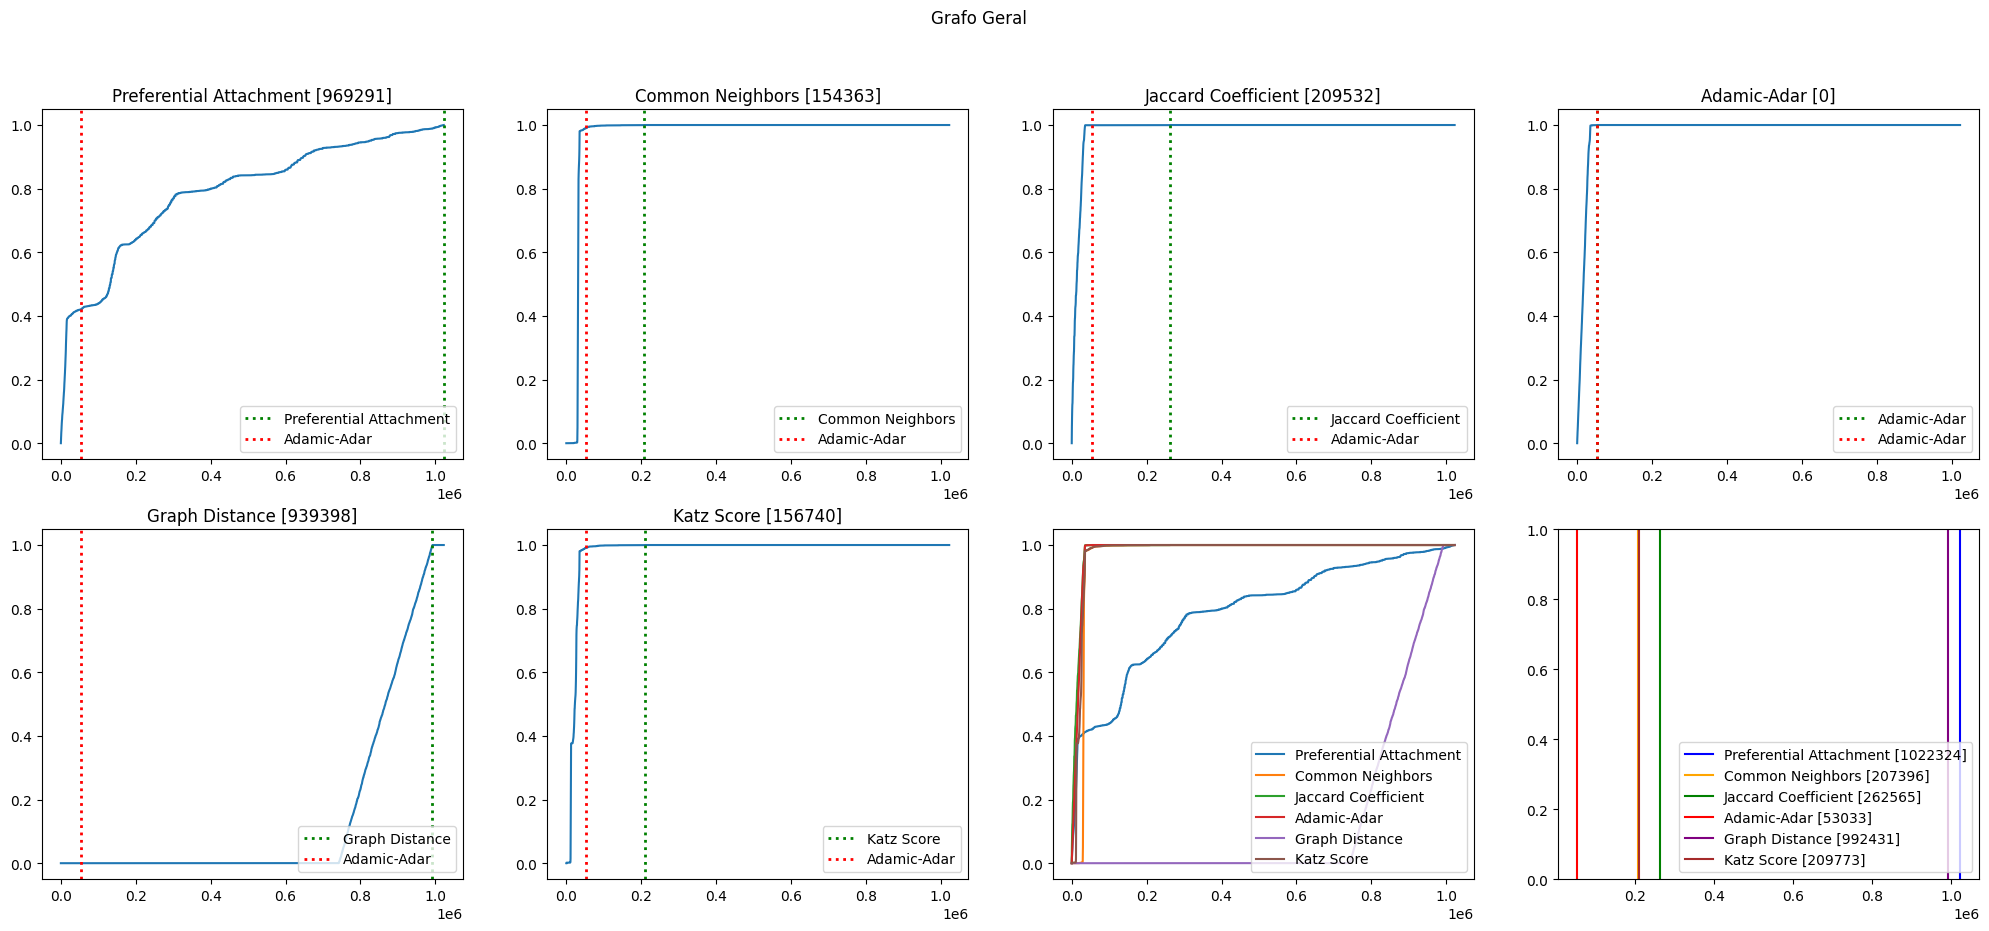

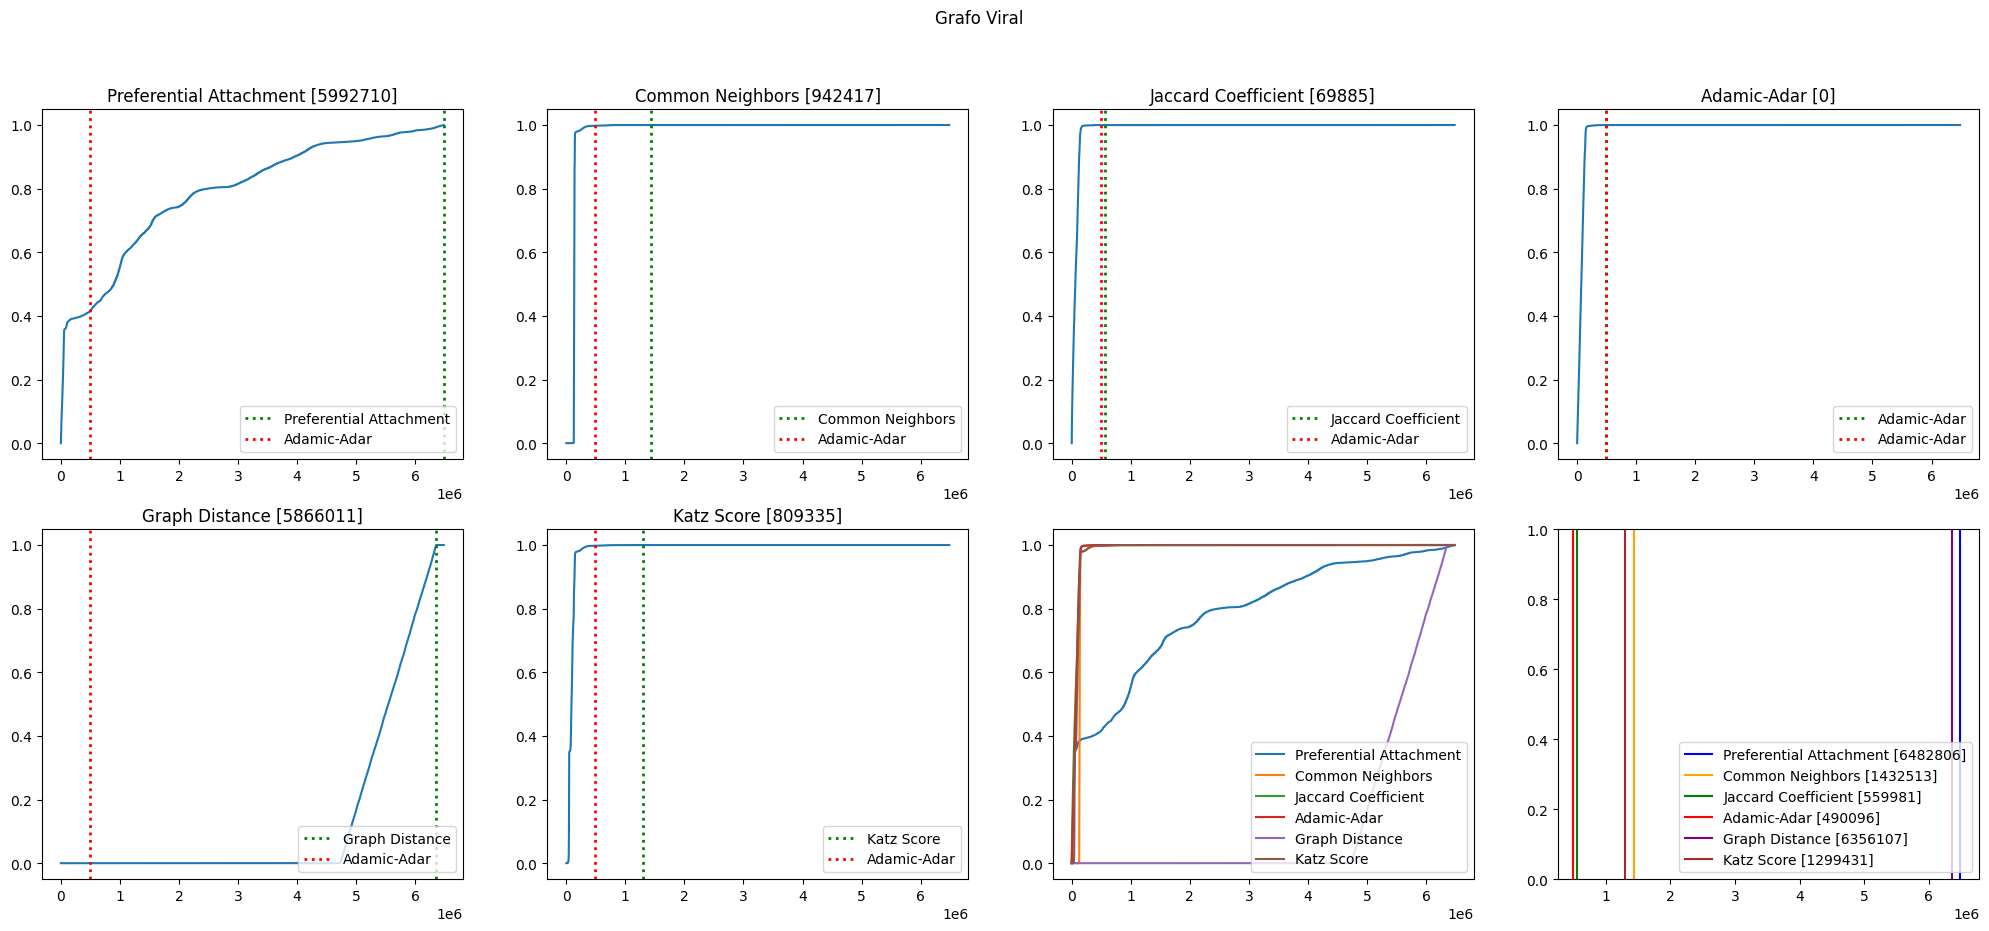

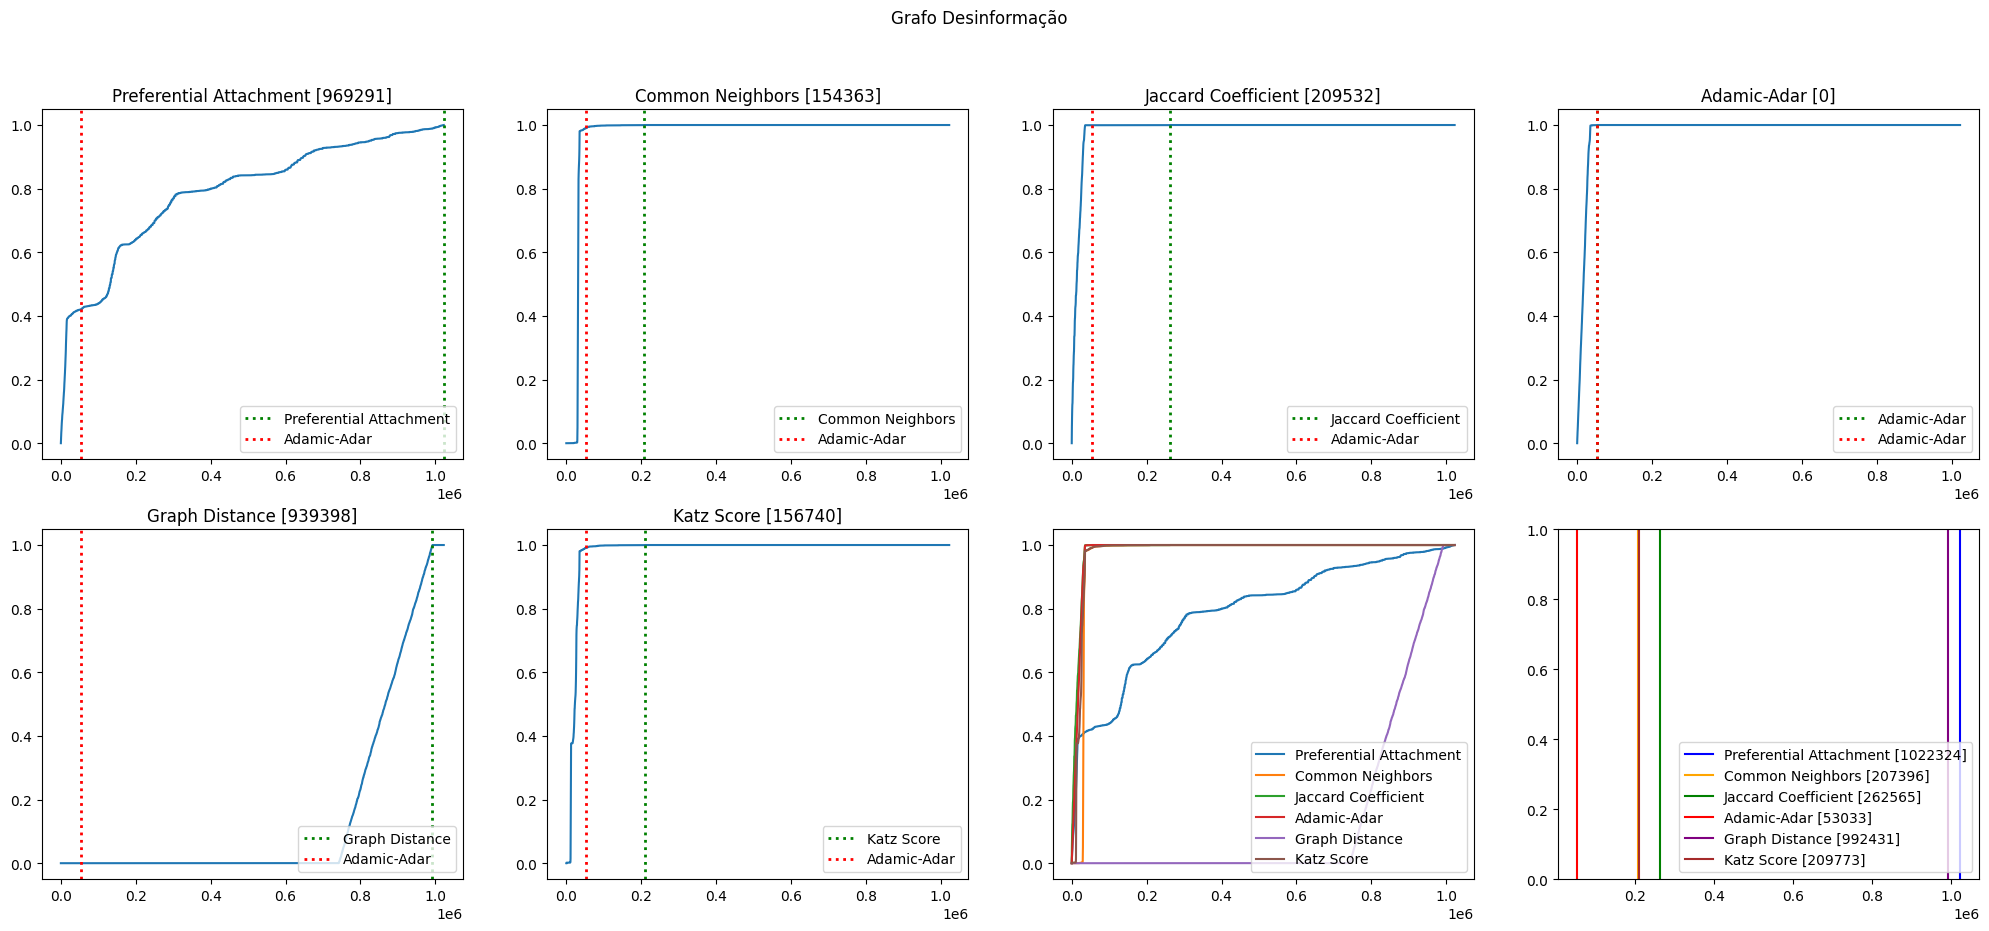

In [55]:
plot(gdf, 'Grafo Geral')
plot(vdf, 'Grafo Viral')
plot(mdf, 'Grafo Desinformação')